In [1]:
from tandem import  TWCFTA, TWFCTA
from simultaneous import T3Clus, TFKMeans, CT3Clus
from simultaneous import CT3Clus
import numpy as np
from utils import PseudoF, OneKMeans
from tensor import fold, unfold
from sklearn.preprocessing import scale
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

import pandas as pd
from tabulate import tabulate

import seaborn as sns
import array_to_latex as a2l

from utils import random_membership_matrix
from utils import singular_vectors

from sklearn.decomposition import PCA

import re

**Varimax Rotation**

In [2]:
def rotate(X, gamma=1, n_max_iter=20, tol=1e-6, method="varimax"):

	"""
    Return rotated components or loading matrix.

    Args:
        X (ndarray) : (IxJ) component scores matrix.
        n_components (int) : number of components to return.
        method (str) : method used for the transformation.
        tol (float) : tolerance for convergence.
        max_iter (int) : maximum number of iteration.

    Returns:
        ndarray: (IxJ) rotated matrix via the specified method.
    """

	nrows, ncols = X.shape
	rotation_matrix = np.eye(ncols)
	var0 = 0
	
	for i in range(n_max_iter):
		rotated_mat = X @ rotation_matrix
		if method == "varimax":
			tmp = (gamma/nrows) * rotated_mat @ np.diag(np.diag(rotated_mat.T @ rotated_mat))
		elif method == "quartimax":
			tmp = 0
		u,s,vh = np.linalg.svd(X.T @ (np.asarray(rotated_mat)**3 - tmp))
		rotation_matrix = u @ vh
		var_new = sum(s)
		if var0 != 0 and var_new < var0 * (1 + tol): break
		
		var0 = var_new

	return X @ rotation_matrix


def sort_loadings_matrix(C_k_r):
	
	# constructs a membership function assigning each object/variable/occasion to factor with largest score.
	# varimax approach. Ignoring possibility of object associated with multiple factors.
	# a thought to remove factor with no association (not implemented tho).

	rot_comps = rotate(C_k_r)

	#  construct membership function for component scores
	C_k_r_labels = np.argmax(abs(rot_comps), axis=1)  # factor assignment list for objects 
	C_k_r_mem = np.zeros(C_k_r.shape)  # initialize membership function matrix for objects
	for i in range(len(C_k_r_labels)):
		p = C_k_r_labels[i]  # choose a random cluster for the i'th object.
		C_k_r_mem[i,p] = 1  # assign object i to cluster p

	# sort rows of membership matrix,, grouping objects belonging to same factor.
	C_k_r_ind_lab = {_:C_k_r_labels[_] for _ in range(len(C_k_r_labels))}  # get dict of object to factor assignment
	C_k_r_ind_lab_sorted = dict(sorted(C_k_r_ind_lab.items(), key=lambda item: item[1], reverse=False))  # get sorted index of members
	C_k_r_mem_sorted = C_k_r_mem[list(C_k_r_ind_lab_sorted.keys())]  # sort membership function for occassions 

	return rot_comps, C_k_r_mem, C_k_r_mem_sorted, C_k_r_ind_lab_sorted


In [3]:
df_ = pd.read_excel('data/Suppl_dataset_S1.xls', sheet_name='Var of interest for MVA', index_col=0)

# remove first 33 redundant lines
df = df_.iloc[33:,:]
# transpose data
df = df.T
# grouping subjects into Normal-0 and ADHD-1 diagnosed
y = np.hstack([np.zeros(20), np.ones(19)])

# Building the tensor
J = 39
X_k_i_j0 = []
for k in range(len(df.columns)//39):
	X_k_i_j0.append(df.iloc[:,J*k:J*(k+1)])
X_k_i_j0 = np.array(X_k_i_j0)
K,I,J = X_k_i_j0.shape

print('Tensor Shape:', f'{I} objects, {J} variables, {K} occasions')

Tensor Shape: 39 objects, 39 variables, 19 occasions


In [4]:
# Building ground-truth U_i_g_labels
X_i_jk = unfold(X_k_i_j0, mode=1)
X_y = np.hstack((X_i_jk,y.reshape(-1,1)))
np.savetxt("data/adhd_formatted.csv", X_y, delimiter=",")  # Saving data to file

# shuffle data objects X, y
perm = np.arange(X_y.shape[0])
np.random.shuffle(perm)
rand_num2 = X_y[perm]

# extract object-membership
X_i_jk = rand_num2[:,:-1]
U_labels = rand_num2[:,-1]
X_k_i_j = fold(X_i_jk, mode=1, shape=(K,I,J))

X_i_jk_scaled = X_i_jk

print('X_k_i_j:',X_k_i_j.shape)
print('X_i_jk_scaled:',X_i_jk_scaled.shape)
print('U_labels:',len(U_labels))

X_k_i_j: (19, 39, 39)
X_i_jk_scaled: (39, 741)
U_labels: 39


In [5]:
# NOTE: not consistent variable-factor across occasions

# # Build actual variable-factor assignments
# fact_encode = {'CUE':0,'CVV':1,'TGT':2}  # encoder
# cols = df.columns
# fact_inds = [re.search('(CUE|CVV|TGT)', col).span() for col in cols]  # extract all factor indices from col texts
# var_factors = [cols[col_ind][fact_inds[col_ind][0]:fact_inds[col_ind][-1]] for col_ind in range(len(cols))]  # extract actual fcators
# B_labels = [fact_encode[fact] for fact in var_factors]  # encoding factors

# print('B_j_q_labels:',len(B_j_q_labels))

# NOTE: variable-factor allocation is consistent so picked only for occasion 1
# Build actual variable-factor assignments
fact_encode = {'AllCon':0,'NoCue':1,'NtCue':2, 'SpCue':3, 'ConTg':4, 'IncTg':5}  # encoder
cols = df.columns
fact_inds = [re.search('(AllCon|NoCue|NtCue|SpCue|ConTg|IncTg)', col).span() for col in cols]  # extract all factor indices from col texts
var_factors = [cols[col_ind][fact_inds[col_ind][0]:fact_inds[col_ind][-1]] for col_ind in range(len(cols))]  # extract actual fcators
B_labels_all = [fact_encode[fact] for fact in var_factors]  # encoding factors

B_labels = B_labels_all[:J]

print('B_labels:',len(B_labels))

B_labels: 39


In [6]:
G,Q,R = 2,6,4  # 2 groups, 3 variable factors, 4 occasion factors

**Tandem Models**

In [7]:
# Xs = []
# Us = []
# Yis = []
# Ygs = []

# cf=TWCFTA(verbose=True, init='random', n_loops=500, n_max_iter=100, tol=5e-3).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# X_i_jk_n = cf.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(cf.C_k_r, cf.B_j_q)
# Us.append(cf.U_i_g)
# Ygs.append(fold(cf.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# fc=TWFCTA(verbose=True, init='random', n_loops=500, n_max_iter=100, tol=3e-5).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# X_i_jk_n = fc.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(fc.C_k_r, fc.B_j_q)
# Us.append(fc.U_i_g)
# Ygs.append(fold(fc.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# pca = PCA(n_components=2)
# fig, axes = plt.subplots(2, R, figsize=(30, 20), sharex=False, sharey=False, dpi=100)
# # fig.suptitle('Pokemon Stats by Generation')

# fig.subplots_adjust(hspace=0.25, wspace=0.25)

# titles = ['TWCFTA','TWFCTA']

# # 
# for clustering in range(2):
# 	# loop through each occasion factor
# 	for r in range(R):
# 		# extract first 2 components
# 		components = pca.fit_transform(Yis[clustering][r])  # get each X face
# 		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
# 		components['cluster']=np.where(Us[clustering])[1]

# 		# plot components in subplot
# 		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
# 		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=20)

# 		# plotting centroids
# 		# if clustering > 0:
# 		cents = pca.fit_transform(Ygs[clustering][r])
# 		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(G), palette=[0,0], legend=False, s=100)

# 		plt.savefig('adhd_Yiqr_tandem_clustering.png')

# # plt.title('', x=0.5, y=0.9)


In [8]:
# pca = PCA(n_components=2)
# fig, axes = plt.subplots(2, R, figsize=(30, 20), sharex=False, sharey=False, dpi=100)
# # fig.suptitle('Pokemon Stats by Generation')

# fig.subplots_adjust(hspace=0.25, wspace=0.25)

# titles = ['TWCFTA','TWFCTA']

# # 
# for clustering in range(2):
# 	# loop through each occasion factor
# 	for r in range(R):
# 		# extract first 2 components
# 		components = pca.fit_transform(Yis[clustering][r])  # get each X face
# 		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
# 		components['cluster']=np.where(Us[clustering])[1]

# 		# plot components in subplot
# 		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
# 		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=20)

# 		# plotting centroids
# 		# if clustering > 0:
# 		cents = pca.fit_transform(Ygs[clustering][r])
# 		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(G), palette=[0,0], legend=False, s=100)

# 		plt.savefig('adhd_Yiqr_tandem_clustering.png')

# # plt.title('', x=0.5, y=0.9)

In [9]:

# Y_i_qr_ct1 = ct1.X_i_jk_scaled @ np.kron(ct1.C_k_r, ct1.B_j_q)
# Y_i_qr_ct0 = ct0.X_i_jk_scaled @ np.kron(ct0.C_k_r, ct0.B_j_q)

# # TWCFTA

# # a2l.to_ltx(cf.U_i_g, frmt = '{:6.0f}', arraytype='bmatrix')

# # Y_g_qr_cf = np.linalg.inv(cf.U_i_g.T@cf.U_i_g) @ cf.U_i_g.T @ cf.X_i_jk_scaled @ np.kron(cf.C_k_r, cf.B_j_q)
# # Y_g_q_r_cf = fold(Y_g_qr_cf, mode=1, shape=(R,G,Q))
# # a2l.to_ltx(Y_g_q_r_cf[0], frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(Y_g_q_r_cf[1], frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(Y_g_q_r_cf[2], frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(Y_g_q_r_cf[3], frmt = '{:6.2f}', arraytype='bmatrix')

# # Y_i_qr_cf = cf.X_i_jk_scaled @ np.kron(cf.C_k_r, cf.B_j_q)
# # Y_i_q_r_cf = fold(Y_i_qr_cf, mode=1, shape=(R,I,Q))
# # a2l.to_ltx(Y_i_q_r_cf[0], frmt = '{:6.3f}', arraytype='tabular')
# # a2l.to_ltx(Y_i_q_r_cf[1], frmt = '{:6.3f}', arraytype='tabular')
# # a2l.to_ltx(Y_i_q_r_cf[2], frmt = '{:6.3f}', arraytype='tabular')
# # a2l.to_ltx(Y_i_q_r_cf[3], frmt = '{:6.3f}', arraytype='tabular')

# # TWFCTA

# # Y_g_qr_fc = np.linalg.inv(fc.U_i_g.T@fc.U_i_g) @ fc.U_i_g.T @ fc.X_i_jk_scaled @ np.kron(fc.C_k_r, fc.B_j_q)
# # Y_g_q_r_fc = fold(Y_g_qr_fc, mode=1, shape=(R,G,Q))
# # a2l.to_ltx(Y_g_q_r_fc[0], frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(Y_g_q_r_fc[1], frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(Y_g_q_r_fc[2], frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(Y_g_q_r_fc[3], frmt = '{:6.2f}', arraytype='bmatrix')

# # Y_i_qr_fc = fc.X_i_jk_scaled @ np.kron(fc.C_k_r, cf.B_j_q)
# # Y_i_q_r_fc = fold(Y_i_qr_fc, mode=1, shape=(R,I,Q))
# # a2l.to_ltx(Y_i_q_r_fc[0], frmt = '{:6.3f}', arraytype='tabular')
# # a2l.to_ltx(Y_i_q_r_fc[1], frmt = '{:6.3f}', arraytype='tabular')
# # a2l.to_ltx(Y_i_q_r_fc[2], frmt = '{:6.3f}', arraytype='tabular')
# # a2l.to_ltx(Y_i_q_r_fc[3], frmt = '{:6.3f}', arraytype='tabular')


**Varimax Rotation**

In [10]:
# # rotation and sorting of factor matrix
# rotated_C_cf, C_k_r_mem_cf, C_k_r_mem_sorted_cf, C_k_r_ind_lab_sorted_cf = sort_loadings_matrix(cf.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_cf, index=[_+1 for _ in C_k_r_ind_lab_sorted_cf.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_cf, B_j_q_mem_cf, B_j_q_mem_sorted_cf, B_j_q_ind_lab_sorted_cf = sort_loadings_matrix(cf.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_cf, index=[_+1 for _ in B_j_q_ind_lab_sorted_cf.keys()], columns=range(1,Q+1), dtype=int) #construct df of results

# # rotation and sorting of factor matrix
# rotated_C_fc, C_k_r_mem_fc, C_k_r_mem_sorted_fc, C_k_r_ind_lab_sorted_fc = sort_loadings_matrix(fc.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_fc, index=[_+1 for _ in C_k_r_ind_lab_sorted_fc.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_fc, B_j_q_mem_fc, B_j_q_mem_sorted_fc, B_j_q_ind_lab_sorted_fc = sort_loadings_matrix(fc.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_fc, index=[_+1 for _ in B_j_q_ind_lab_sorted_fc.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # to latex rotated matrices
# # a2l.to_ltx(rotated_B_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(rotated_C_cf, frmt = '{:6.2f}', arraytype='bmatrix')

# # a2l.to_ltx(rotated_B_fc, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(rotated_C_fc, frmt = '{:6.2f}', arraytype='bmatrix')

# # # to latex membership matrices
# # a2l.to_ltx(B_j_q_mem_cf, frmt = '{:6.0f}', arraytype='bmatrix')
# # a2l.to_ltx(C_k_r_mem_cf, frmt = '{:6.0f}', arraytype='bmatrix')

# # a2l.to_ltx(B_j_q_mem_fc, frmt = '{:6.0f}', arraytype='bmatrix')
# # a2l.to_ltx(C_k_r_mem_fc, frmt = '{:6.0f}', arraytype='bmatrix')


**Metrics**

In [11]:
# # Rand and Pseudo F metrics
# U_rand_cf = adjusted_rand_score(np.where(cf.U_i_g)[1], U_labels)
# B_rand_cf = adjusted_rand_score(np.where(B_j_q_mem_cf)[1], B_labels)
# # C_rand_cf = adjusted_rand_score(np.where(C_k_r_mem_cf)[1], C_labels)

# U_rand_fc = adjusted_rand_score(np.where(fc.U_i_g)[1], U_labels)
# B_rand_fc = adjusted_rand_score(np.where(B_j_q_mem_fc)[1], B_labels)
# # C_rand_fc = adjusted_rand_score(np.where(C_k_r_mem_fc)[1], C_labels)

# print('TWCFTA:', cf.BSS/cf.TSS, cf.PseudoF, U_rand_cf, B_rand_cf)
# print('TWFCTA:', fc.BSS/fc.TSS, fc.PseudoF, U_rand_fc, B_rand_fc)
# print()
# print('TWCFTA TSS_BSS:', cf.TSS, cf.BSS)
# print("TWFCTA TSS_BSS:", fc.TSS, fc.BSS)


In [12]:
# print(cf.BestLoop)
# print(fc.BestLoop)
# print()
# print(cf.BestFAIteration)
# print(cf.BestKMIteration)
# print()
# print(fc.BestFAIteration)
# print(fc.BestKMIteration)

**Simultaneous Models**

In [13]:
# # PLOTTING THE COMPONENTS

# Xs = []
# Us = []
# Yis = []
# Ygs = []

# ct0 = TFKMeans(verbose=True, init='random', n_loops=500, n_max_iter=100, tol=5e-3).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# X_i_jk_n = ct0.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct0.C_k_r, ct0.B_j_q)
# Us.append(ct0.U_i_g)
# Ygs.append(fold(ct0.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct1 = T3Clus(verbose=True, init='random', n_loops=500, n_max_iter=100, tol=5e-3).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R))
# X_i_jk_n = ct1.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct1.C_k_r, ct1.B_j_q)
# Us.append(ct1.U_i_g)
# Ygs.append(fold(ct1.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 20

# pca = PCA(n_components=2)
# fig, axes = plt.subplots(2, R, figsize=(30, 20), sharex=False, sharey=False, dpi=100)
# # fig.suptitle('Pokemon Stats by Generation')

# fig.subplots_adjust(hspace=0.25, wspace=0.25)

# titles = ['3FKMeans','T3Clus']

# # 
# for clustering in range(2):
# 	# loop through each occasion factor
# 	for r in range(R):
# 		# extract first 2 components
# 		components = pca.fit_transform(Yis[clustering][r])  # get each X face
# 		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
# 		components['cluster']=np.where(Us[clustering])[1]

# 		# plot components in subplot
# 		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
# 		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=20)

# 		# plotting centroids
# 		# if clustering > 0:
# 		cents = pca.fit_transform(Ygs[clustering][r])
# 		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(2), palette=[0,0], legend=False, s=100)

# 		plt.savefig('adhd_Yiqr_simultaneous_clustering.png')

In [14]:
# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 20

# pca = PCA(n_components=2)
# fig, axes = plt.subplots(2, R, figsize=(30, 20), sharex=False, sharey=False, dpi=100)
# # fig.suptitle('Pokemon Stats by Generation')

# fig.subplots_adjust(hspace=0.25, wspace=0.25)

# titles = ['3FKMeans','T3Clus']

# # 
# for clustering in range(2):
# 	# loop through each occasion factor
# 	for r in range(R):
# 		# extract first 2 components
# 		components = pca.fit_transform(Yis[clustering][r])  # get each X face
# 		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
# 		components['cluster']=np.where(Us[clustering])[1]

# 		# plot components in subplot
# 		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
# 		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=20)

# 		# plotting centroids
# 		# if clustering > 0:
# 		cents = pca.fit_transform(Ygs[clustering][r])
# 		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(2), palette=[0,0], legend=False, s=100)

# 		plt.savefig('adhd_Yiqr_simultaneous_clustering.png')

In [15]:
# # TSS, BSS%, PF, 
# print('TWCFTA:',np.array([cf.TSS,cf.BSS/cf.TSS*100,cf.PseudoF]).round(2))
# print('TWFCTA:',np.array([fc.TSS,fc.BSS/fc.TSS*100,fc.PseudoF]).round(2))
# print()
# print('T3Clus:',np.array([ct1.TSS,ct1.BSS/ct1.TSS*100,ct1.PseudoF]).round(2))
# print('3FKMeans:',np.array([ct0.TSS,ct0.BSS/ct0.TSS*100,ct0.PseudoF]).round(2))

In [16]:
# # Objective functional values
# # print('TWCFTA_km:',cf.Fs_km)
# # print('TWCFTA_fa:',cf.Fs_fa)
# # print()
# # print('TWFCTA_km:',fc.Fs_km)
# # print('TWFCTA_fa:',fc.Fs_fa)
# # print()
# print('T3Clus:',ct1.Fs)
# print('3FKMeans:',ct0.Fs)

In [17]:
# # get iterates
# U_i_g0_ct0 = ct0.U_i_g0
# B_j_q0_ct0 = ct0.B_j_q0
# C_k_r0_ct0 = ct0.C_k_r0
# U_i_g_ct0 = ct0.U_i_g
# B_j_q_ct0 = ct0.B_j_q
# C_k_r_ct0 = ct0.C_k_r
# Y_g_qr_ct0 = ct0.Y_g_qr
# X_i_jk_ct0 = ct0.X_i_jk_scaled
# Y_i_qr_ct0 = ct0.X_i_jk_scaled @ np.kron(C_k_r_ct0, B_j_q_ct0)

# U_i_g0_ct1 = ct1.U_i_g0
# B_j_q0_ct1 = ct1.B_j_q0
# C_k_r0_ct1 = ct1.C_k_r0
# U_i_g_ct1 = ct1.U_i_g
# B_j_q_ct1 = ct1.B_j_q
# C_k_r_ct1 = ct1.C_k_r
# Y_g_qr_ct1 = ct1.Y_g_qr
# X_i_jk_ct1 = ct1.X_i_jk_scaled
# Y_i_qr_ct1 = ct1.X_i_jk_scaled @ np.kron(C_k_r_ct1, B_j_q_ct1)

# a2l.to_ltx(U_i_g_cf, frmt = '{:6.0f}', arraytype='bmatrix')
# a2l.to_ltx(B_j_q0_cf, frmt = '{:6.3f}', arraytype='bmatrix')
# a2l.to_ltx(C_k_r0_cf, frmt = '{:6.3f}', arraytype='bmatrix')


# T3Clus

# Y_g_qr_ct1 = ct1.Y_g_qr
# Y_g_q_r_ct1 = fold(Y_g_qr_ct1, mode=1, shape=(R,G,Q))
# a2l.to_ltx(Y_g_q_r_ct1[0], frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(Y_g_q_r_ct1[1], frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(Y_g_q_r_ct1[2], frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(Y_g_q_r_ct1[3], frmt = '{:6.2f}', arraytype='bmatrix')

# Y_i_qr_ct1 = ct1.X_i_jk_scaled @ np.kron(ct1.C_k_r, ct1.B_j_q)
# Y_i_q_r_ct1 = fold(Y_i_qr_ct1, mode=1, shape=(R,I,Q))
# a2l.to_ltx(Y_i_q_r_ct1[0], frmt = '{:6.2f}', arraytype='tabular')
# a2l.to_ltx(Y_i_q_r_ct1[1], frmt = '{:6.2f}', arraytype='tabular')
# a2l.to_ltx(Y_i_q_r_ct1[2], frmt = '{:6.2f}', arraytype='tabular')
# a2l.to_ltx(Y_i_q_r_ct1[3], frmt = '{:6.2f}', arraytype='tabular')

# 3FKMeans

# Y_g_qr_ct0 = ct0.Y_g_qr
# Y_g_q_r_ct0 = fold(Y_g_qr_ct0, mode=1, shape=(R,G,Q))
# a2l.to_ltx(Y_g_q_r_ct0[0], frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(Y_g_q_r_ct0[1], frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(Y_g_q_r_ct0[2], frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(Y_g_q_r_ct0[3], frmt = '{:6.2f}', arraytype='bmatrix')

# Y_i_qr_ct0 = ct0.X_i_jk_scaled @ np.kron(ct0.C_k_r, ct0.B_j_q)
# Y_i_q_r_ct0 = fold(Y_i_qr_ct0, mode=1, shape=(R,I,Q))
# a2l.to_ltx(Y_i_q_r_ct0[0], frmt = '{:6.2f}', arraytype='tabular')
# a2l.to_ltx(Y_i_q_r_ct0[1], frmt = '{:6.2f}', arraytype='tabular')
# a2l.to_ltx(Y_i_q_r_ct0[2], frmt = '{:6.2f}', arraytype='tabular')
# a2l.to_ltx(Y_i_q_r_ct0[3], frmt = '{:6.2f}', arraytype='tabular')


# a2l.to_ltx(U_i_g_fc, frmt = '{:6.0f}', arraytype='bmatrix')
# a2l.to_ltx(B_j_q_fc, frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(C_k_r_fc, frmt = '{:6.2f}', arraytype='bmatrix')



**Varimax Rotation**

In [18]:
# # rotation and sorting of factor matrix
# rotated_C_ct0, C_k_r_mem_ct0, C_k_r_mem_sorted_ct0, C_k_r_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct0, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct0.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct0, B_j_q_mem_ct0, B_j_q_mem_sorted_ct0, B_j_q_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct0, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct0.keys()], columns=range(1,Q+1), dtype=int) #construct df of results

# # rotation and sorting of factor matrix
# rotated_C_ct1, C_k_r_mem_ct1, C_k_r_mem_sorted_ct1, C_k_r_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct1, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct1.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct1, B_j_q_mem_ct1, B_j_q_mem_sorted_ct1, B_j_q_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct1, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct1.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # to latex rotated matrices
# # a2l.to_ltx(rotated_B_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(rotated_C_cf, frmt = '{:6.2f}', arraytype='bmatrix')

# # a2l.to_ltx(rotated_B_fc, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(rotated_C_fc, frmt = '{:6.2f}', arraytype='bmatrix')

# # # to latex membership matrices
# # a2l.to_ltx(B_j_q_mem_cf, frmt = '{:6.0f}', arraytype='bmatrix')
# # a2l.to_ltx(C_k_r_mem_cf, frmt = '{:6.0f}', arraytype='bmatrix')

# # a2l.to_ltx(B_j_q_mem_fc, frmt = '{:6.0f}', arraytype='bmatrix')
# # a2l.to_ltx(C_k_r_mem_fc, frmt = '{:6.0f}', arraytype='bmatrix')


**Metrics**

In [19]:
# # Rand and Pseudo F metrics
# U_rand_ct0 = adjusted_rand_score(np.where(ct0.U_i_g)[1], U_labels)
# B_rand_ct0 = adjusted_rand_score(np.where(B_j_q_mem_ct0)[1], B_labels)
# # C_rand_cf = adjusted_rand_score(np.where(C_k_r_mem_cf)[1], C_labels)

# U_rand_ct1 = adjusted_rand_score(np.where(ct1.U_i_g)[1], U_labels)
# B_rand_ct1 = adjusted_rand_score(np.where(B_j_q_mem_ct1)[1], B_labels)
# # C_rand_fc = adjusted_rand_score(np.where(C_k_r_mem_fc)[1], C_labels)


# # BSS%, PF, Urand, Brand
# print('T3Clus:', np.array([ct1.BSS/ct1.TSS*100, ct1.PseudoF, U_rand_ct1, B_rand_ct1]).round(3))
# print('TFKMeans:', np.array([ct0.BSS/ct0.TSS*100, ct0.PseudoF, U_rand_ct0, B_rand_ct0]).round(3))


**Varying Alphas (Simultaneous)**

*Random*

In [20]:
# # PLOTTING THE COMPONENTS

# Xs = []
# Us = []
# Yis = []
# Ygs = []

# ct0 = CT3Clus(
# 	verbose=True, init='random', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0)
# X_i_jk_n = ct0.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct0.C_k_r, ct0.B_j_q)
# Us.append(ct0.U_i_g)
# Ygs.append(fold(ct0.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct025 = CT3Clus(
# 	verbose=True, init='random', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.25)
# X_i_jk_n = ct025.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct025.C_k_r, ct025.B_j_q)
# Us.append(ct025.U_i_g)
# Ygs.append(fold(ct025.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct05 = CT3Clus(
# 	verbose=True, init='random', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.5)
# X_i_jk_n = ct05.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct05.C_k_r, ct05.B_j_q)
# Us.append(ct05.U_i_g)
# Ygs.append(fold(ct05.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct075 = CT3Clus(
# 	verbose=True, init='random', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.75)
# X_i_jk_n = ct075.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct075.C_k_r, ct075.B_j_q)
# Us.append(ct075.U_i_g)
# Ygs.append(fold(ct075.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct1 = CT3Clus(
# 	verbose=True, init='random', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=1)
# X_i_jk_n = ct1.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct1.C_k_r, ct1.B_j_q)
# Us.append(ct1.U_i_g)
# Ygs.append(fold(ct1.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))


In [21]:

# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 20

# pca = PCA(n_components=2)
# fig, axes = plt.subplots(5, R, figsize=(30, 30), sharex=False, sharey=False, dpi=100)
# # fig.suptitle('Pokemon Stats by Generation')

# fig.subplots_adjust(hspace=0.35, wspace=0.25)

# titles = ['a=0','a=0.25','a=0.5','a=0.75','a=1']

# # 
# for clustering in range(5):
# 	# loop through each occasion factor
# 	for r in range(R):
# 		# extract first 2 components
# 		components = pca.fit_transform(Yis[clustering][r])  # get each X face
# 		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
# 		components['cluster']=np.where(Us[clustering])[1]

# 		# plot components in subplot
# 		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
# 		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=20)

# 		# plotting centroids
# 		# if clustering > 0:
# 		cents = pca.fit_transform(Ygs[clustering][r])
# 		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(2), palette=[0,0], legend=False, s=100)

# 		plt.savefig('adhd_Yiqr_ct3Clus_random.png')

In [22]:
# # tss,bss,pseudof
# print('ct0',np.array([ct0.TSS,ct0.BSS/ct0.TSS*100,ct0.PseudoF]).round(2))
# print('ct025',np.array([ct025.TSS,ct025.BSS/ct025.TSS*100,ct025.PseudoF]).round(2))
# print('ct05',np.array([ct05.TSS,ct05.BSS/ct05.TSS*100,ct05.PseudoF]).round(2))
# print('ct075',np.array([ct075.TSS,ct075.BSS/ct075.TSS*100,ct075.PseudoF]).round(2))
# print('ct1',np.array([ct1.TSS,ct1.BSS/ct1.TSS*100,ct1.PseudoF]).round(2))

**Varimax Rotation**

In [23]:
# # rotation and sorting of factor matrix
# rotated_C_ct0, C_k_r_mem_ct0, C_k_r_mem_sorted_ct0, C_k_r_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct0, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct0.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct0, B_j_q_mem_ct0, B_j_q_mem_sorted_ct0, B_j_q_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct0, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct0.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct025, C_k_r_mem_ct025, C_k_r_mem_sorted_ct025, C_k_r_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct025, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct025.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct025, B_j_q_mem_ct025, B_j_q_mem_sorted_ct025, B_j_q_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct025, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct025.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct05, C_k_r_mem_ct05, C_k_r_mem_sorted_ct05, C_k_r_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct05, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct05.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct05, B_j_q_mem_ct05, B_j_q_mem_sorted_ct05, B_j_q_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct05, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct05.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct075, C_k_r_mem_ct075, C_k_r_mem_sorted_ct075, C_k_r_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct075, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct075.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct075, B_j_q_mem_ct075, B_j_q_mem_sorted_ct075, B_j_q_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct075, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct075.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct1, C_k_r_mem_ct1, C_k_r_mem_sorted_ct1, C_k_r_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct1, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct1.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct1, B_j_q_mem_ct1, B_j_q_mem_sorted_ct1, B_j_q_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct1, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct1.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # to latex rotated matrices
# # a2l.to_ltx(rotated_B_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(rotated_C_cf, frmt = '{:6.2f}', arraytype='bmatrix')


**Metrics**

In [24]:
# # Rand and Pseudo F metrics
# U_rand_ct0 = adjusted_rand_score(np.where(ct0.U_i_g)[1], U_labels)
# B_rand_ct0 = adjusted_rand_score(np.where(B_j_q_mem_ct0)[1], B_labels)
# # C_rand_cf = adjusted_rand_score(np.where(C_k_r_mem_cf)[1], C_labels)

# U_rand_ct025 = adjusted_rand_score(np.where(ct025.U_i_g)[1], U_labels)
# B_rand_ct025 = adjusted_rand_score(np.where(B_j_q_mem_ct025)[1], B_labels)

# U_rand_ct05 = adjusted_rand_score(np.where(ct05.U_i_g)[1], U_labels)
# B_rand_ct05 = adjusted_rand_score(np.where(B_j_q_mem_ct05)[1], B_labels)

# U_rand_ct075 = adjusted_rand_score(np.where(ct075.U_i_g)[1], U_labels)
# B_rand_ct075 = adjusted_rand_score(np.where(B_j_q_mem_ct075)[1], B_labels)

# U_rand_ct1 = adjusted_rand_score(np.where(ct1.U_i_g)[1], U_labels)
# B_rand_ct1 = adjusted_rand_score(np.where(B_j_q_mem_ct1)[1], B_labels)
# # C_rand_fc = adjusted_rand_score(np.where(C_k_r_mem_fc)[1], C_labels)


# # BSS%, PF, Urand, Brand
# print('CT0:', np.array([ct0.Fs[0],ct0.Fs[1],U_rand_ct0, B_rand_ct0]).round(3))
# print('CT025:', np.array([ct025.Fs[0],ct025.Fs[1],U_rand_ct025, B_rand_ct025]).round(3))
# print('CT05:', np.array([ct05.Fs[0],ct05.Fs[1],U_rand_ct05, B_rand_ct05]).round(3))
# print('CT075:', np.array([ct075.Fs[0],ct075.Fs[1],U_rand_ct075, B_rand_ct075]).round(3))
# print('CT1:', np.array([ct1.Fs[0],ct1.Fs[1],U_rand_ct1, B_rand_ct1]).round(3))


**TWCFTA Initialization**

In [25]:
# # PLOTTING THE COMPONENTS

# Xs = []
# Us = []
# Yis = []
# Ygs = []

# ct0 = CT3Clus(
# 	verbose=True, init='twcfta', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0)
# X_i_jk_n = ct0.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct0.C_k_r, ct0.B_j_q)
# Us.append(ct0.U_i_g)
# Ygs.append(fold(ct0.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct025 = CT3Clus(
# 	verbose=True, init='twcfta', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.25)
# X_i_jk_n = ct025.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct025.C_k_r, ct025.B_j_q)
# Us.append(ct025.U_i_g)
# Ygs.append(fold(ct025.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct05 = CT3Clus(
# 	verbose=True, init='twcfta', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.5)
# X_i_jk_n = ct05.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct05.C_k_r, ct05.B_j_q)
# Us.append(ct05.U_i_g)
# Ygs.append(fold(ct05.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct075 = CT3Clus(
# 	verbose=True, init='twcfta', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.75)
# X_i_jk_n = ct075.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct075.C_k_r, ct075.B_j_q)
# Us.append(ct075.U_i_g)
# Ygs.append(fold(ct075.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct1 = CT3Clus(
# 	verbose=True, init='twcfta', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=1)
# X_i_jk_n = ct1.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct1.C_k_r, ct1.B_j_q)
# Us.append(ct1.U_i_g)
# Ygs.append(fold(ct1.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))


In [26]:

# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 20

# pca = PCA(n_components=2)
# fig, axes = plt.subplots(5, R, figsize=(30, 30), sharex=False, sharey=False, dpi=100)
# # fig.suptitle('Pokemon Stats by Generation')

# fig.subplots_adjust(hspace=0.35, wspace=0.25)

# titles = ['a=0','a=0.25','a=0.5','a=0.75','a=1']

# # 
# for clustering in range(5):
# 	# loop through each occasion factor
# 	for r in range(R):
# 		# extract first 2 components
# 		components = pca.fit_transform(Yis[clustering][r])  # get each X face
# 		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
# 		components['cluster']=np.where(Us[clustering])[1]

# 		# plot components in subplot
# 		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
# 		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=20)

# 		# plotting centroids
# 		# if clustering > 0:
# 		cents = pca.fit_transform(Ygs[clustering][r])
# 		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(2), palette=[0,0], legend=False, s=100)

# 		plt.savefig('adhd_Yiqr_ct3Clus_twcfta.png')

In [27]:
# # tss,bss,pseudof
# print('ct0',np.array([ct0.TSS,ct0.BSS/ct0.TSS*100,ct0.PseudoF]).round(2))
# print('ct025',np.array([ct025.TSS,ct025.BSS/ct025.TSS*100,ct025.PseudoF]).round(2))
# print('ct05',np.array([ct05.TSS,ct05.BSS/ct05.TSS*100,ct05.PseudoF]).round(2))
# print('ct075',np.array([ct075.TSS,ct075.BSS/ct075.TSS*100,ct075.PseudoF]).round(2))
# print('ct1',np.array([ct1.TSS,ct1.BSS/ct1.TSS*100,ct1.PseudoF]).round(2))

**Varimax**

In [28]:
# # rotation and sorting of factor matrix
# rotated_C_ct0, C_k_r_mem_ct0, C_k_r_mem_sorted_ct0, C_k_r_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct0, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct0.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct0, B_j_q_mem_ct0, B_j_q_mem_sorted_ct0, B_j_q_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct0, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct0.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct025, C_k_r_mem_ct025, C_k_r_mem_sorted_ct025, C_k_r_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct025, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct025.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct025, B_j_q_mem_ct025, B_j_q_mem_sorted_ct025, B_j_q_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct025, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct025.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct05, C_k_r_mem_ct05, C_k_r_mem_sorted_ct05, C_k_r_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct05, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct05.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct05, B_j_q_mem_ct05, B_j_q_mem_sorted_ct05, B_j_q_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct05, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct05.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct075, C_k_r_mem_ct075, C_k_r_mem_sorted_ct075, C_k_r_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct075, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct075.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct075, B_j_q_mem_ct075, B_j_q_mem_sorted_ct075, B_j_q_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct075, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct075.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct1, C_k_r_mem_ct1, C_k_r_mem_sorted_ct1, C_k_r_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct1, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct1.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct1, B_j_q_mem_ct1, B_j_q_mem_sorted_ct1, B_j_q_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct1, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct1.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # to latex rotated matrices
# # a2l.to_ltx(rotated_B_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(rotated_C_cf, frmt = '{:6.2f}', arraytype='bmatrix')


**Metrics**

In [29]:
# # Rand and Pseudo F metrics
# U_rand_ct0 = adjusted_rand_score(np.where(ct0.U_i_g)[1], U_labels)
# B_rand_ct0 = adjusted_rand_score(np.where(B_j_q_mem_ct0)[1], B_labels)
# # C_rand_cf = adjusted_rand_score(np.where(C_k_r_mem_cf)[1], C_labels)

# U_rand_ct025 = adjusted_rand_score(np.where(ct025.U_i_g)[1], U_labels)
# B_rand_ct025 = adjusted_rand_score(np.where(B_j_q_mem_ct025)[1], B_labels)

# U_rand_ct05 = adjusted_rand_score(np.where(ct05.U_i_g)[1], U_labels)
# B_rand_ct05 = adjusted_rand_score(np.where(B_j_q_mem_ct05)[1], B_labels)

# U_rand_ct075 = adjusted_rand_score(np.where(ct075.U_i_g)[1], U_labels)
# B_rand_ct075 = adjusted_rand_score(np.where(B_j_q_mem_ct075)[1], B_labels)

# U_rand_ct1 = adjusted_rand_score(np.where(ct1.U_i_g)[1], U_labels)
# B_rand_ct1 = adjusted_rand_score(np.where(B_j_q_mem_ct1)[1], B_labels)
# # C_rand_fc = adjusted_rand_score(np.where(C_k_r_mem_fc)[1], C_labels)


# # F0, F, Urand, Brand
# print('CT0:', np.array([ct0.Fs[0],ct0.Fs[-1],U_rand_ct0, B_rand_ct0]).round(3))
# print('CT025:', np.array([ct025.Fs[0],ct025.Fs[-1],U_rand_ct025, B_rand_ct025]).round(3))
# print('CT05:', np.array([ct05.Fs[0],ct05.Fs[-1],U_rand_ct05, B_rand_ct05]).round(3))
# print('CT075:', np.array([ct075.Fs[0],ct075.Fs[-1],U_rand_ct075, B_rand_ct075]).round(3))
# print('CT1:', np.array([ct1.Fs[0],ct1.Fs[-1],U_rand_ct1, B_rand_ct1]).round(3))


**TWFCTA Initialization**

In [30]:
# # PLOTTING THE COMPONENTS

# Xs = []
# Us = []
# Yis = []
# Ygs = []

# ct0 = CT3Clus(
# 	verbose=True, init='twfcta', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0)
# X_i_jk_n = ct0.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct0.C_k_r, ct0.B_j_q)
# Us.append(ct0.U_i_g)
# Ygs.append(fold(ct0.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct025 = CT3Clus(
# 	verbose=True, init='twfcta', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.25)
# X_i_jk_n = ct025.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct025.C_k_r, ct025.B_j_q)
# Us.append(ct025.U_i_g)
# Ygs.append(fold(ct025.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct05 = CT3Clus(
# 	verbose=True, init='twfcta', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.5)
# X_i_jk_n = ct05.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct05.C_k_r, ct05.B_j_q)
# Us.append(ct05.U_i_g)
# Ygs.append(fold(ct05.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct075 = CT3Clus(
# 	verbose=True, init='twfcta', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.75)
# X_i_jk_n = ct075.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct075.C_k_r, ct075.B_j_q)
# Us.append(ct075.U_i_g)
# Ygs.append(fold(ct075.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

# ct1 = CT3Clus(
# 	verbose=True, init='twfcta', n_loops=500, n_max_iter=100, tol=5e-3
# 	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=1)
# X_i_jk_n = ct1.X_i_jk_scaled
# Y_i_qr = X_i_jk_n@np.kron(ct1.C_k_r, ct1.B_j_q)
# Us.append(ct1.U_i_g)
# Ygs.append(fold(ct1.Y_g_qr, mode=1, shape=(R,G,Q)))
# Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))


In [31]:

# plt.rcParams['axes.labelsize'] = 20
# plt.rcParams['axes.titlesize'] = 20

# pca = PCA(n_components=2)
# fig, axes = plt.subplots(5, R, figsize=(30, 30), sharex=False, sharey=False, dpi=100)
# # fig.suptitle('Pokemon Stats by Generation')

# fig.subplots_adjust(hspace=0.35, wspace=0.25)

# titles = ['a=0','a=0.25','a=0.5','a=0.75','a=1']

# # 
# for clustering in range(5):
# 	# loop through each occasion factor
# 	for r in range(R):
# 		# extract first 2 components
# 		components = pca.fit_transform(Yis[clustering][r])  # get each X face
# 		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
# 		components['cluster']=np.where(Us[clustering])[1]

# 		# plot components in subplot
# 		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
# 		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=20)

# 		# plotting centroids
# 		# if clustering > 0:
# 		cents = pca.fit_transform(Ygs[clustering][r])
# 		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
# 		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(2), palette=[0,0], legend=False, s=100)

# 		plt.savefig('adhd_Yiqr_ct3Clus_twfcta.png')

In [32]:
# # tss,bss,pseudof
# print('ct0',np.array([ct0.TSS,ct0.BSS/ct0.TSS*100,ct0.PseudoF]).round(2))
# print('ct025',np.array([ct025.TSS,ct025.BSS/ct025.TSS*100,ct025.PseudoF]).round(2))
# print('ct05',np.array([ct05.TSS,ct05.BSS/ct05.TSS*100,ct05.PseudoF]).round(2))
# print('ct075',np.array([ct075.TSS,ct075.BSS/ct075.TSS*100,ct075.PseudoF]).round(2))
# print('ct1',np.array([ct1.TSS,ct1.BSS/ct1.TSS*100,ct1.PseudoF]).round(2))

**Varimax**

In [33]:
# # rotation and sorting of factor matrix
# rotated_C_ct0, C_k_r_mem_ct0, C_k_r_mem_sorted_ct0, C_k_r_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct0, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct0.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct0, B_j_q_mem_ct0, B_j_q_mem_sorted_ct0, B_j_q_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct0, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct0.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct025, C_k_r_mem_ct025, C_k_r_mem_sorted_ct025, C_k_r_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct025, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct025.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct025, B_j_q_mem_ct025, B_j_q_mem_sorted_ct025, B_j_q_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct025, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct025.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct05, C_k_r_mem_ct05, C_k_r_mem_sorted_ct05, C_k_r_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct05, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct05.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct05, B_j_q_mem_ct05, B_j_q_mem_sorted_ct05, B_j_q_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct05, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct05.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct075, C_k_r_mem_ct075, C_k_r_mem_sorted_ct075, C_k_r_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct075, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct075.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct075, B_j_q_mem_ct075, B_j_q_mem_sorted_ct075, B_j_q_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct075, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct075.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # rotation and sorting of factor matrix
# rotated_C_ct1, C_k_r_mem_ct1, C_k_r_mem_sorted_ct1, C_k_r_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.C_k_r)
# df_C = pd.DataFrame(C_k_r_mem_sorted_ct1, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct1.keys()], columns=range(1,R+1), dtype=int) #construct df of results

# rotated_B_ct1, B_j_q_mem_ct1, B_j_q_mem_sorted_ct1, B_j_q_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.B_j_q)
# df_B = pd.DataFrame(B_j_q_mem_sorted_ct1, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct1.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# # to latex rotated matrices
# # a2l.to_ltx(rotated_B_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# # a2l.to_ltx(rotated_C_cf, frmt = '{:6.2f}', arraytype='bmatrix')


In [34]:
# # Rand and Pseudo F metrics
# U_rand_ct0 = adjusted_rand_score(np.where(ct0.U_i_g)[1], U_labels)
# B_rand_ct0 = adjusted_rand_score(np.where(B_j_q_mem_ct0)[1], B_labels)
# # C_rand_cf = adjusted_rand_score(np.where(C_k_r_mem_cf)[1], C_labels)

# U_rand_ct025 = adjusted_rand_score(np.where(ct025.U_i_g)[1], U_labels)
# B_rand_ct025 = adjusted_rand_score(np.where(B_j_q_mem_ct025)[1], B_labels)

# U_rand_ct05 = adjusted_rand_score(np.where(ct05.U_i_g)[1], U_labels)
# B_rand_ct05 = adjusted_rand_score(np.where(B_j_q_mem_ct05)[1], B_labels)

# U_rand_ct075 = adjusted_rand_score(np.where(ct075.U_i_g)[1], U_labels)
# B_rand_ct075 = adjusted_rand_score(np.where(B_j_q_mem_ct075)[1], B_labels)

# U_rand_ct1 = adjusted_rand_score(np.where(ct1.U_i_g)[1], U_labels)
# B_rand_ct1 = adjusted_rand_score(np.where(B_j_q_mem_ct1)[1], B_labels)
# # C_rand_fc = adjusted_rand_score(np.where(C_k_r_mem_fc)[1], C_labels)


# # F0, F, Iteration, Urand, Brand
# print('CT0:', np.array([ct0.Fs[0],ct0.Fs[-1], ct0.BestIteration, U_rand_ct0, B_rand_ct0]).round(3))
# print('CT025:', np.array([ct025.Fs[0],ct025.Fs[-1],ct025.BestIteration,U_rand_ct025, B_rand_ct025]).round(3))
# print('CT05:', np.array([ct05.Fs[0],ct05.Fs[-1],ct05.BestIteration,U_rand_ct05, B_rand_ct05]).round(3))
# print('CT075:', np.array([ct075.Fs[0],ct075.Fs[-1],ct075.BestIteration,U_rand_ct075, B_rand_ct075]).round(3))
# print('CT1:', np.array([ct1.Fs[0],ct1.Fs[-1],ct1.BestIteration,U_rand_ct1, B_rand_ct1]).round(3))


**SVD Initialization**

In [35]:
# PLOTTING THE COMPONENTS

Xs = []
Us = []
Yis = []
Ygs = []

ct0 = CT3Clus(
	verbose=True, init='svd', n_loops=500, n_max_iter=100, tol=5e-3
	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0)
X_i_jk_n = ct0.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(ct0.C_k_r, ct0.B_j_q)
Us.append(ct0.U_i_g)
Ygs.append(fold(ct0.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

ct025 = CT3Clus(
	verbose=True, init='svd', n_loops=500, n_max_iter=100, tol=5e-3
	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.25)
X_i_jk_n = ct025.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(ct025.C_k_r, ct025.B_j_q)
Us.append(ct025.U_i_g)
Ygs.append(fold(ct025.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

ct05 = CT3Clus(
	verbose=True, init='svd', n_loops=500, n_max_iter=100, tol=5e-3
	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.5)
X_i_jk_n = ct05.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(ct05.C_k_r, ct05.B_j_q)
Us.append(ct05.U_i_g)
Ygs.append(fold(ct05.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

ct075 = CT3Clus(
	verbose=True, init='svd', n_loops=500, n_max_iter=100, tol=5e-3
	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=0.75)
X_i_jk_n = ct075.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(ct075.C_k_r, ct075.B_j_q)
Us.append(ct075.U_i_g)
Ygs.append(fold(ct075.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))

ct1 = CT3Clus(
	verbose=True, init='svd', n_loops=500, n_max_iter=100, tol=5e-3
	).fit(X_i_jk=X_i_jk_scaled, full_tensor_shape=(I,J,K), reduced_tensor_shape=(G,Q,R), alpha=1)
X_i_jk_n = ct1.X_i_jk_scaled
Y_i_qr = X_i_jk_n@np.kron(ct1.C_k_r, ct1.B_j_q)
Us.append(ct1.U_i_g)
Ygs.append(fold(ct1.Y_g_qr, mode=1, shape=(R,G,Q)))
Yis.append(fold(Y_i_qr, mode=1, shape=(R,I,Q)))


Loop    Iteration    Loop time    BSS (%)    PseudoF    Convergence
------  -----------  -----------  ---------  ---------  -------------
1    17    0.8517    10.7681    12.4566    True
Loop    Iteration    Loop time    BSS (%)    PseudoF    Convergence
------  -----------  -----------  ---------  ---------  -------------
1    19    0.9193    9.7339    11.1312    True
Loop    Iteration    Loop time    BSS (%)    PseudoF    Convergence
------  -----------  -----------  ---------  ---------  -------------
1    17    0.8101    15.2869    18.6272    True
Loop    Iteration    Loop time    BSS (%)    PseudoF    Convergence
------  -----------  -----------  ---------  ---------  -------------
1    8    0.3947    6.0794    6.6816    True
Loop    Iteration    Loop time    BSS (%)    PseudoF    Convergence
------  -----------  -----------  ---------  ---------  -------------
1    5    0.2573    10.8793    12.6008    True


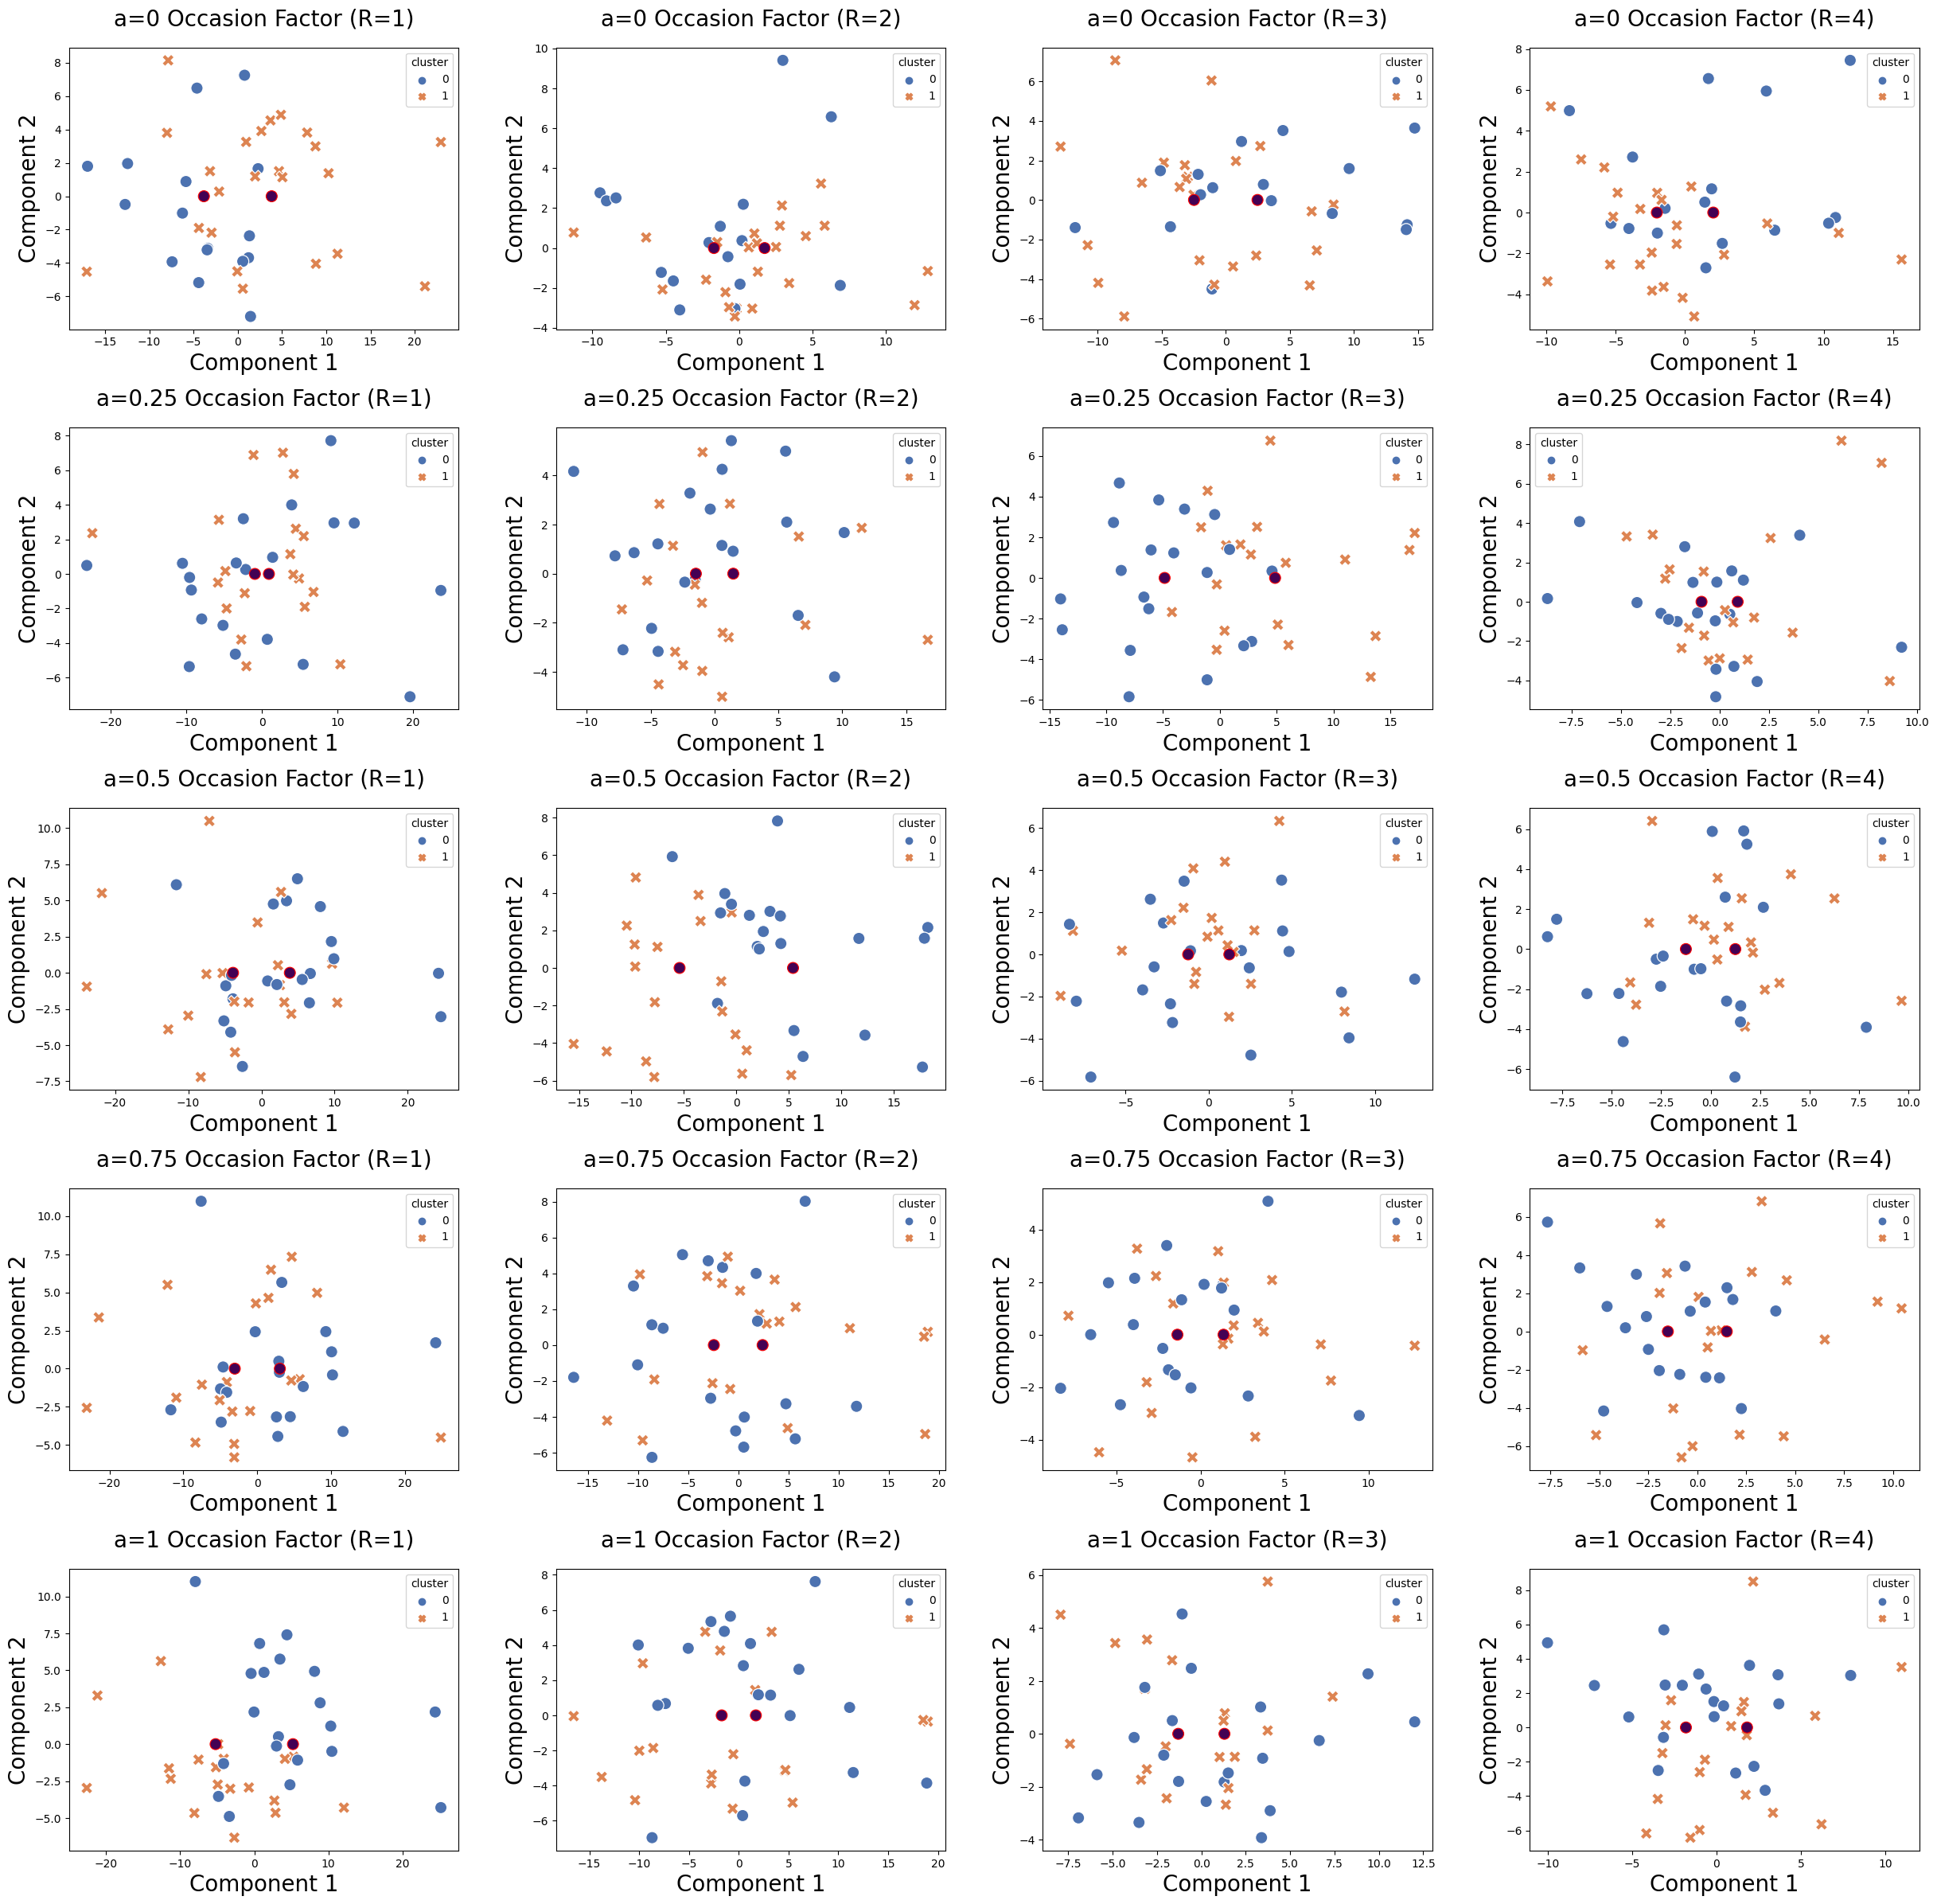

In [36]:

plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 20

pca = PCA(n_components=2)
fig, axes = plt.subplots(5, R, figsize=(30, 30), sharex=False, sharey=False, dpi=100)
# fig.suptitle('Pokemon Stats by Generation')

fig.subplots_adjust(hspace=0.35, wspace=0.25)

titles = ['a=0','a=0.25','a=0.5','a=0.75','a=1']

# 
for clustering in range(5):
	# loop through each occasion factor
	for r in range(R):
		# extract first 2 components
		components = pca.fit_transform(Yis[clustering][r])  # get each X face
		components = pd.DataFrame(components, columns=['Component 1', 'Component 2'])
		components['cluster']=np.where(Us[clustering])[1]

		# plot components in subplot
		sns.scatterplot(ax=axes[clustering, r], data=components, x='Component 1', y='Component 2', hue="cluster", style="cluster", palette="deep", s=120)
		axes[clustering, r].set_title(f'{titles[clustering]} Occasion Factor (R={r+1})', pad=20)

		# plotting centroids
		# if clustering > 0:
		cents = pca.fit_transform(Ygs[clustering][r])
		cents = pd.DataFrame(cents, columns=['Component 1', 'Component 2'])
		sns.scatterplot(ax=axes[clustering, r], data=cents, x='Component 1', y='Component 2', ec='red', hue=range(2), palette=[0,0], legend=False, s=100)

		plt.savefig('adhd_Yiqr_ct3Clus_svd.png')

In [37]:
# tss,bss,pseudof
print('ct0',np.array([ct0.TSS,ct0.BSS/ct0.TSS*100,ct0.PseudoF]).round(2))
print('ct025',np.array([ct025.TSS,ct025.BSS/ct025.TSS*100,ct025.PseudoF]).round(2))
print('ct05',np.array([ct05.TSS,ct05.BSS/ct05.TSS*100,ct05.PseudoF]).round(2))
print('ct075',np.array([ct075.TSS,ct075.BSS/ct075.TSS*100,ct075.PseudoF]).round(2))
print('ct1',np.array([ct1.TSS,ct1.BSS/ct1.TSS*100,ct1.PseudoF]).round(2))

ct0 [9791.78   10.77   12.46]
ct025 [1.100368e+04 9.730000e+00 1.113000e+01]
ct05 [12090.52    15.29    18.63]
ct075 [1.241497e+04 6.080000e+00 6.680000e+00]
ct1 [1.260852e+04 1.088000e+01 1.260000e+01]


**Varimax**

In [38]:
# rotation and sorting of factor matrix
rotated_C_ct0, C_k_r_mem_ct0, C_k_r_mem_sorted_ct0, C_k_r_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_ct0, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct0.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_ct0, B_j_q_mem_ct0, B_j_q_mem_sorted_ct0, B_j_q_ind_lab_sorted_ct0 = sort_loadings_matrix(ct0.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_ct0, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct0.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# rotation and sorting of factor matrix
rotated_C_ct025, C_k_r_mem_ct025, C_k_r_mem_sorted_ct025, C_k_r_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_ct025, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct025.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_ct025, B_j_q_mem_ct025, B_j_q_mem_sorted_ct025, B_j_q_ind_lab_sorted_ct025 = sort_loadings_matrix(ct025.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_ct025, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct025.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# rotation and sorting of factor matrix
rotated_C_ct05, C_k_r_mem_ct05, C_k_r_mem_sorted_ct05, C_k_r_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_ct05, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct05.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_ct05, B_j_q_mem_ct05, B_j_q_mem_sorted_ct05, B_j_q_ind_lab_sorted_ct05 = sort_loadings_matrix(ct05.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_ct05, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct05.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# rotation and sorting of factor matrix
rotated_C_ct075, C_k_r_mem_ct075, C_k_r_mem_sorted_ct075, C_k_r_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_ct075, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct075.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_ct075, B_j_q_mem_ct075, B_j_q_mem_sorted_ct075, B_j_q_ind_lab_sorted_ct075 = sort_loadings_matrix(ct075.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_ct075, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct075.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# rotation and sorting of factor matrix
rotated_C_ct1, C_k_r_mem_ct1, C_k_r_mem_sorted_ct1, C_k_r_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.C_k_r)
df_C = pd.DataFrame(C_k_r_mem_sorted_ct1, index=[_+1 for _ in C_k_r_ind_lab_sorted_ct1.keys()], columns=range(1,R+1), dtype=int) #construct df of results

rotated_B_ct1, B_j_q_mem_ct1, B_j_q_mem_sorted_ct1, B_j_q_ind_lab_sorted_ct1 = sort_loadings_matrix(ct1.B_j_q)
df_B = pd.DataFrame(B_j_q_mem_sorted_ct1, index=[_+1 for _ in B_j_q_ind_lab_sorted_ct1.keys()], columns=range(1,Q+1), dtype=int) #construct df of results


# to latex rotated matrices
# a2l.to_ltx(rotated_B_cf, frmt = '{:6.2f}', arraytype='bmatrix')
# a2l.to_ltx(rotated_C_cf, frmt = '{:6.2f}', arraytype='bmatrix')


**Metrics**

In [39]:
# Rand and Pseudo F metrics
U_rand_ct0 = adjusted_rand_score(np.where(ct0.U_i_g)[1], U_labels)
B_rand_ct0 = adjusted_rand_score(np.where(B_j_q_mem_ct0)[1], B_labels)
# C_rand_cf = adjusted_rand_score(np.where(C_k_r_mem_cf)[1], C_labels)

U_rand_ct025 = adjusted_rand_score(np.where(ct025.U_i_g)[1], U_labels)
B_rand_ct025 = adjusted_rand_score(np.where(B_j_q_mem_ct025)[1], B_labels)

U_rand_ct05 = adjusted_rand_score(np.where(ct05.U_i_g)[1], U_labels)
B_rand_ct05 = adjusted_rand_score(np.where(B_j_q_mem_ct05)[1], B_labels)

U_rand_ct075 = adjusted_rand_score(np.where(ct075.U_i_g)[1], U_labels)
B_rand_ct075 = adjusted_rand_score(np.where(B_j_q_mem_ct075)[1], B_labels)

U_rand_ct1 = adjusted_rand_score(np.where(ct1.U_i_g)[1], U_labels)
B_rand_ct1 = adjusted_rand_score(np.where(B_j_q_mem_ct1)[1], B_labels)
# C_rand_fc = adjusted_rand_score(np.where(C_k_r_mem_fc)[1], C_labels)


# F0, F, Iteration, Urand, Brand
print('CT0:', np.array([ct0.Fs[0],ct0.Fs[-1], ct0.BestIteration, U_rand_ct0, B_rand_ct0]).round(3))
print('CT025:', np.array([ct025.Fs[0],ct025.Fs[-1],ct025.BestIteration,U_rand_ct025, B_rand_ct025]).round(3))
print('CT05:', np.array([ct05.Fs[0],ct05.Fs[-1],ct05.BestIteration,U_rand_ct05, B_rand_ct05]).round(3))
print('CT075:', np.array([ct075.Fs[0],ct075.Fs[-1],ct075.BestIteration,U_rand_ct075, B_rand_ct075]).round(3))
print('CT1:', np.array([ct1.Fs[0],ct1.Fs[-1],ct1.BestIteration,U_rand_ct1, B_rand_ct1]).round(3))


CT0: [ 1.3596e+01  3.2471e+01  1.7000e+01  7.0000e-03 -3.6000e-02]
CT025: [ 1.5366e+01  3.2727e+01  1.9000e+01  2.8000e-02 -9.4000e-02]
CT05: [ 1.6768e+01  4.2991e+01  1.7000e+01 -2.1000e-02 -9.4000e-02]
CT075: [ 1.6681e+01  2.7473e+01  8.0000e+00 -2.1000e-02 -9.4000e-02]
CT1: [ 2.0142e+01  3.7037e+01  5.0000e+00 -2.1000e-02 -9.4000e-02]
